# Grafi di *De Brujin* e Cammini Euleriani

I grafi di de Brujin rappresentano $k$-meri di un insieme di stringhe $S$. Ogni nodo è associato a un $(k-1)$-mero presente in $S$. Esiste un arco orientato dal nodo $a$ al nodo $b$, se c'è un $k$-mero in $S$ tale che il prefisso di lunghezza $k-1$ del $k$-mero corrisponde ad $a$ e il suffisso di lunghezza $k-1$ del $k$-mero corrisponde a $b$.

Un cammino è Euleriano se tocca tutti gli archi di un grafo una sola volta. Si può dimostrare che i grafi di de Brujin costruiti a partire da read con copertura uniforme e senza errori di sequenziamento sono Euleriani.

Quindi, per assemblare le read in una sequenza di riferimento, possiamo costruire il grafo di de Brujin a partire dalle read e trovare un cammino Euleriano su di esso. 

In [1]:
# importo i tipi per fare inferenza dei tipi (non necessaria)
from typing import List, Iterable, Tuple

In [2]:
def get_kmers(string: str, k: int) -> List[str]:
    """Suddivide una stringa nei suoi k-meri

    Questa funzione calcola le sottostringhe contigue
    di una stringa di lunghezza k.
    """
    kmers = []
    for i in range(len(string)-k+1):
        kmers.append(string[i:i+k])

    return kmers

La seguente classe definisce il tipo `DeBrujin` che rappresenta i grafi di de Brujin. La struttura di grafo diretto è ereditata da `network.DiGraph`. Il costruttore può prendere come parametri un insieme di stringhe e il valore $k$.

Il seguente codice non è ottimizzato e ha uno scopo didattico.

In [3]:
import networkx as nx
import matplotlib.pyplot as plt

In [5]:
class DeBrujin(nx.DiGraph):        
    """Grafo di De Brujin

    Questa classe rappresenta i grafi di De Brujin. Ogni nodo rappresenta
    un (k-1)-mero di una read. Ogni arco rappresenta un k-mero e unisce
    il prefisso e il suffisso del k-mero stesso
    """

    class NodeDegree(object):
        """Numero di archi entranti/uscenti da un nodo"""

        def __init__(self):
            self.indegree = 0
            self.outdegree = 0

        def balance(self):
            return self.indegree-self.outdegree

    def __init__(self, reads: Iterable[str] = None, k: int = 0):
        """Inzializza un grafo di De Brujin"""
        assert reads is None or k>1

        super().__init__()

        self.degree = dict()

        if reads is not None:  
            # per ogni read
            for read in reads:
                # per ogni posizione ammissibile per l'inizio di un k-mero
                for i in range(len(read) - k + 1):
                    kmer_prefix = read[i:i+k-1]
                    kmer_suffix = read[i+1:i+k]
                    self.add_edge(kmer_prefix, kmer_suffix)

    def copy(self):
        """Fai una copia profonda del grafo

        Questo metodo fa una copia della struttura dati
        allocando nuove aree di memoria.
        """
        G = DeBrujin()
        for src, dst in self.edges():
            G.add_edge(src, dst)

        return G
            
    def add_edge(self, src: str, dst: str) -> None:
        """Aggiungi un arco tra due nodi

        Questo metodo aggiunge un arco al grafo aggiornando
        la struttura dati.
        """
        if self.has_edge(src, dst):
            self[src][dst]["occurrences"] += 1
        else:
            super().add_edge(src, dst, occurrences=1)

        for node in [src, dst]:
            if node not in self.degree:
                self.degree[node] = DeBrujin.NodeDegree()

        self.degree[src].outdegree += 1
        self.degree[dst].indegree += 1

    def remove_edge(self, src: str, dst: str) -> None:
        """Rimuove un arco tra due nodi

        Questo metodo rimuove un arco al grafo aggiornando
        la struttura dati.
        """
        assert self.has_edge(src, dst)

        self[src][dst]["occurrences"] -= 1
        
        if self[src][dst]["occurrences"] == 0:
            super().remove_edge(src, dst)

        self.degree[src].outdegree -= 1
        self.degree[dst].indegree -= 1

    def num_of_balanced(self) -> int:
        """Restituisce il numero di nodi bilanciati"""
        num_bal = 0
        for node, degree in self.degree.items():
            if degree.balance() == 0:
                num_bal += 1

        return num_bal

    def num_of_semi_balanced(self) -> int:
        """Restituisce il numero di nodi semi-bilanciati"""
        num_semi = 0
        for node, degree in self.degree.items():
            if abs(degree.balance()) == 1:
                num_semi += 1

        return num_semi
        
    def is_Eulerian(self) -> bool:
        """Verifica se un grafo è Euleriano

        Se tutti i nodi sono bilanciati o semi-bilanciati e
        il numero di semi-bilanciati è al più 2 allora il 
        grafo è Eureliano.
        """
        num_bal = self.num_of_balanced()
        num_semi = self.num_of_semi_balanced()
    
        return num_bal+num_semi == len(self) and num_semi <= 2

    def has_Eulerian_cycle(self) -> bool:
        """Verifica se un grafo ha un ciclo Euleriano

        Se tutti i nodi sono bilanciati allora tutte le 
        componenti connesse contengono cicli Euleriani.
        """
        return self.num_of_balanced() == len(self)

    def get_sinks(self) -> List[str]:
        """Restitisce i nodi che non hanno archi uscenti"""
        nodes = list()

        for node, degree in self.degree.items():
            if degree.outdegree == 0:
                nodes.append(node)

        return nodes

    def get_sources(self) -> List[str]:
        """Restitisce i nodi che non hanno archi entranti"""
        nodes = list()

        for node, degree in self.degree.items():
            if degree.indegree == 0:
                nodes.append(node)

        return nodes

    def get_max_coverage_neighbor(self, src:str) -> str:
        """Trova il vicino il cui arco ha copertura massima"""
        assert src in self.nodes

        candidate = None
        max_coverage = 0
        for neighbor in self.neighbors(src):
            if max_coverage < self[src][neighbor]["occurrences"]:
                candidate = neighbor
                max_coverage = self[src][neighbor]["occurrences"]

        return candidate
    
    def get_Eulerian_walk(self) -> List[str]:
        """Trova un cammino Euleriano attraverso il grafo"""
        if not self.has_Eulerian_cycle():
            # non ho un ciclo devo aggiungere un arco tra
            # il nodo con bilancio positivo (sink) e il
            # nodo con bilancio negativo (source)
            source = self.get_sources()[0]
            sink = self.get_sinks()[0]

            G = self.copy()

            G.add_edge(sink, source)
        else:
            source = next(self.balance.keys())
            G = self.copy()

        walk = []
        def __visit(node):
            while G.degree[node].outdegree > 0:
                next_node = G.get_max_coverage_neighbor(node)

                G.remove_edge(node, next_node)
                __visit(next_node)
            walk.append(node)

        __visit(source)
        walk = walk[::-1][:-1]

        return walk


    def assembly(self) -> str:
        """Assembla i k-meri rappresentati nel grafo"""
        text = ""
        walk = self.get_Eulerian_walk()

        text = walk[0]
        for node in walk[1:]:
            text += node[-1]

        return text
    
    def plot(self) -> None:
        """Disegna un grafo di De Brujin"""

        # trova la posizione dei nodi e degli archi
        pos = nx.kamada_kawai_layout(self)

        # disegna i nodi
        nx.draw(self, pos, with_labels=True, arrows=True)

        # estrai l'attributo degli archi "occurrences" 
        edge_labels = nx.get_edge_attributes(self, "occurrences")

        # disegna gli archi e le etichette "occurrences"
        nx.draw_networkx_edge_labels(self, pos,
                                           edge_labels=edge_labels)

        # mostra il disegno
        plt.show()
        

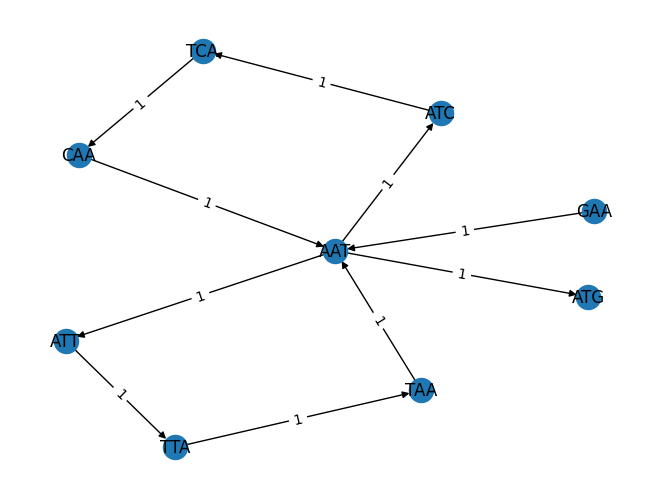

In [11]:
# definiamo una lista di read contenente una sola read
reads = ["GAATCAATTAATG"]

# costruiamo il grafo di de Brujin della read con k=4
G = DeBrujin(reads, 4)

# disegnamo il grafo di de Brujin
G.plot()

In [12]:
# produciamo una stringa che corrisponda ai k-meri rappresentati nel grafo
assembled = G.assembly()

print(f"The original reads are {reads}")
print(f"The assembled sequence is {assembled}")

The original reads are ['GAATCAATTAATG']
The assembled sequence is GAATCAATTAATG


## Errori di sequenziamento

Gli errori di sequenziamento possono generare grafi non Euleriani e il cui assemblaggio si discosta significativamente dal DNA sequenziato.

Proviamo a sequenziare una striga di DNA al 30x. Assumiamo di essere MOLTO fortunati e di avere read di lunghezza pari alla stringa da sequenziare. Questo non capita mai, ma ci serve per mostrare gli effetti degli errori di sequenziamento anche nelle condizioni migliori. Aggiungiamo 3 errori: 1 una read e 2 in un'altra.

In [41]:
# consideriamo una sequenza di DNA
original_sequence = "GCGTATTACGCGTCTGGCCT"

# sequenziamola al 30x
reads2 = [original_sequence]*30

# introduciamo 1 errore nella read 0
reads2[0]=reads2[0][0:10]+"A"+reads2[0][11:]

# introduciamo 2 errori nella read 1
reads2[1]=reads2[1][0:9]+"A"+reads2[1][10:13]+"A"+reads2[1][14:]

Costruiamo il grado di de Brujin corrispondente con $k=9$.

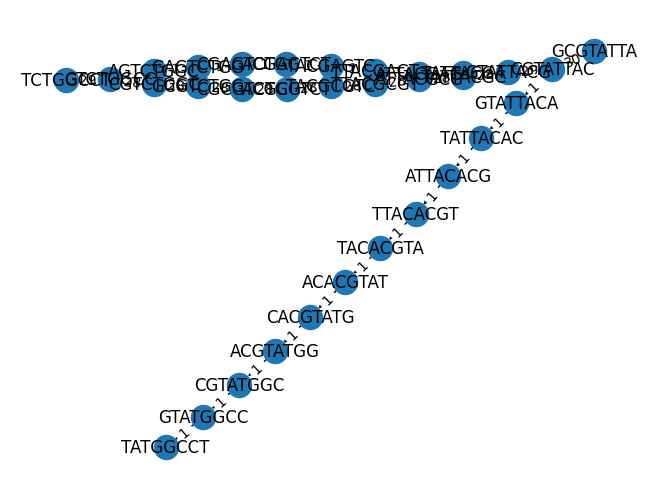

In [42]:
# costruiamo il grafo corrispondente con k=9
k = 9
G = DeBrujin(reads2, k)

G.plot()

In [43]:
G.is_Eulerian()

False

Il grafo ottenuto non Euleriano e l'assemblato è molto diverso da quello che ci aspetteremmo.

In [44]:
assembled2 = G.assembly()


print(f"The original sequence is {original_sequence}")
print(f"The assembled sequence is {assembled2}")

The original sequence is GCGTATTACGCGTCTGGCCT
The assembled sequence is GCGTATTACACGTATGGCCTGCGTCTGGCCAGTCTGGCCT


### Altri Vantaggi delle Read Senza Errori

Se le read non contengono errori di sequenziamento e la copertura è uniforme, il grafo di de Brujin corrispondente ad un insieme di read è Euleriano. Inoltre, lo spazio richiesto per rappresentare il grafo è $O(\min(|G|, l*n))$ dove $G$ è il genoma sequenziato, $l$ è la lunghezza delle read sequenziate e $n$ è il numero di read sequenziate. È facile vedere che $l*n=|G|*c$ dove $c$ è la copertura media di sequenziamento. Quindi, eliminare gli errori di sequenziamento, non solo semplifica l'assemblaggio delle sequenze, ma riduce lo spazio necessario a rappresentare il grafo di de Brujin delle read.

### Trovare e Correggere gli Errori

Per correggere gli errori di sequenziamento, utilizziamo la statistica. Esistono $4^k$ $k$-meri diversi (4 è il numero di basi del DNA), ma una stringa $s$ qualsiasi contiene esattamente $|s|-k+1$ istanze di $k$-meri. Però tra queste istanze ve ne potrebbero essere alcune associate allo stesso $k$-mero. Quindi la generica stringa $s$ contiene **al più** $|s|-k+1$ $k$-meri.
Per esempio, la stringa "GCGTATTACGCGTCTGGCCT" contiene 13 $8$-meri diversi, ma esistono $4^8 = 65.536$ $8$-meri costruiti con 4 basi.
Ne segue che ogni errore produrrà con alta probabilità un $k$-mero che non è presente tra quelli sequenziati. Per correggerlo, ci basterà trovare il $k$-mero più vicino che occorre più frequentemente tra le read sequenziate.

In [45]:
from typing import Dict

def count_kmers(reads: Iterable[str], k: int) -> Dict[str, int]:
    """Conta i k-meri delle read

    Questa funzione conta i k-meri presenti tra le read e restituisce
    un dizionario che associa ad ogni k-mero il numero di occorrenze
    di questo nelle read.
    """
    assert k>0

    count = dict()

    for read in reads:
        for kmers in get_kmers(read, k):
            if kmers in count:
                count[kmers] += 1
            else:
                count[kmers] = 1

    return count

Contiamo i $8$-meri nelle read.

In [46]:
count = count_kmers(reads2, 8)

count

{'GCGTATTA': 30,
 'CGTATTAC': 30,
 'GTATTACG': 29,
 'TATTACGA': 1,
 'ATTACGAG': 1,
 'TTACGAGT': 1,
 'TACGAGTC': 1,
 'ACGAGTCT': 1,
 'CGAGTCTG': 1,
 'GAGTCTGG': 1,
 'AGTCTGGC': 1,
 'GTCTGGCC': 29,
 'TCTGGCCT': 29,
 'GTATTACA': 1,
 'TATTACAC': 1,
 'ATTACACG': 1,
 'TTACACGT': 1,
 'TACACGTA': 1,
 'ACACGTAT': 1,
 'CACGTATG': 1,
 'ACGTATGG': 1,
 'CGTATGGC': 1,
 'GTATGGCC': 1,
 'TATGGCCT': 1,
 'TATTACGC': 28,
 'ATTACGCG': 28,
 'TTACGCGT': 28,
 'TACGCGTC': 28,
 'ACGCGTCT': 28,
 'CGCGTCTG': 28,
 'GCGTCTGG': 28,
 'CGTCTGGC': 28}

In [47]:
def plot_kmer_coverage(read: str, count: Dict[str, int], threshold_error: int=None):
    """Disegna il profilo di occorrenze di ogni $k$-mero di una read"""

    if len(count)==0:
        k = 1
    else:
        k = len(next(iter(count.keys())))

    x = []
    y = []
    for i in range(len(read) - k+1):
        kmer = read[i:i+k]

        x.append(i+1)
        y.append(0 if kmer not in count else count[kmer])

    if threshold_error is not None:
        plt.axhline(y=threshold_error, color='red', linestyle='--', label='Soglia errore')
    
    plt.plot(x, y, marker='o', color='blue')

    plt.ylim(0, max(y)+2)

    # Aggiungi titoli e etichette agli assi
    plt.ylabel("# Occorrenze", fontsize=14)
    plt.xlabel("Posizione nella Read", fontsize=14)
    
    # Mostra il grafico
    plt.show()

Disegnamo il profilo di occorrenze degli $8$-meri delle read $0$, $1$, e $2$ fissando come soglia per identificare gli errori $3$ occorrenze. Tale soglia è arbitraria e deve dipendere dalla copertura media.

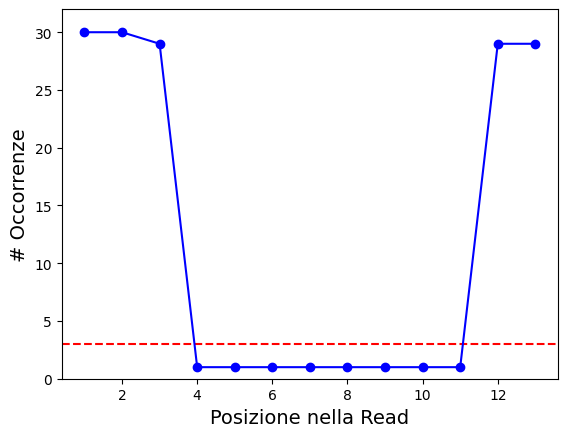

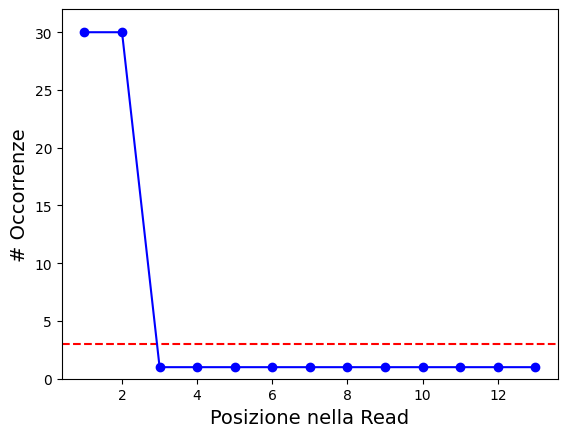

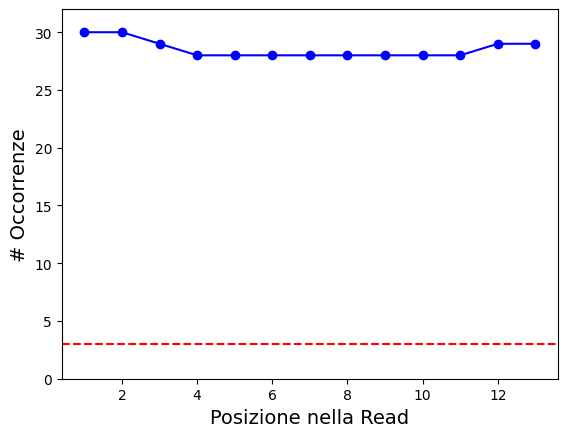

In [48]:
threshold_error=3

plot_kmer_coverage(reads2[0], count, threshold_error=threshold_error)
plot_kmer_coverage(reads2[1], count, threshold_error=threshold_error)
plot_kmer_coverage(reads2[2], count, threshold_error=threshold_error)

Le read $0$ e $1$ contengono degli errori. La read $2$ no.

Correggiamo gli errori tenendo conto di quando si verifica il primo errore nella read. Se il primo $k$-mero ad avere un numero di occorrenze sotto soglia è l'$i$-esimo della read, allora $(i-1)$-esimo $k$-mero non contiene errori e l'errore si trova in posizione $i+k-1$. Per correggerlo, cerchiamo il $k$-mero con numero di occorrenze massime tra quelli che si discostano da quello che vogliamo correggere per l'ultima base.

In [34]:
def fix_last_base(count: Dict[str, int], kmer: str) -> str:
    fixed_base = None
    max_occurrences = 0
    for base in ['A', 'C', 'G', 'T']:
        candidate = kmer[:-1] + base
        
        if candidate is None or (candidate in count and count[candidate]>max_occurrences):
            max_occurrences = count[candidate]
            fixed_base = base
        
    return fixed_base

def fix_error(reads: Iterable[str], k: int, coverage_threshold: int) -> List[str]:
    count = count_kmers(reads, k)

    fixed = []

    # per ogni read
    for read in reads:
        fixed_read = read
        for i in range(len(fixed_read) - k+1):
            k1mer = fixed_read[i:i+k]

            if k1mer not in count or count[k1mer]<coverage_threshold:
                fixed_base = fix_last_base(count, k1mer)
                fixed_read = fixed_read[:i+k-1]+fixed_base+fixed_read[i+k:]
        fixed.append(fixed_read)

    return fixed

Correggiamo le read considerando come errori tutti i $k$-meri che occorrono meno di 3 volte nelle read.

In [50]:
fixed_reads2 = fix_error(reads2, k, 3)

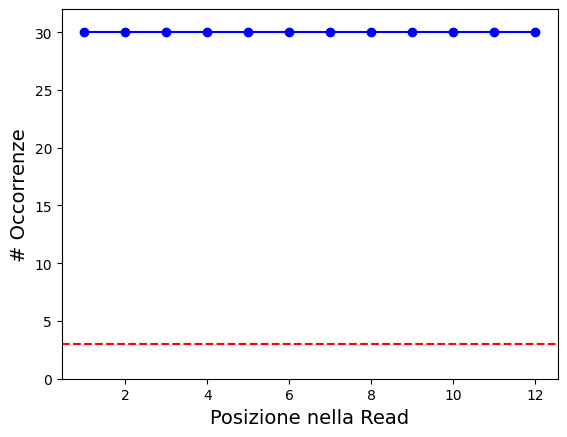

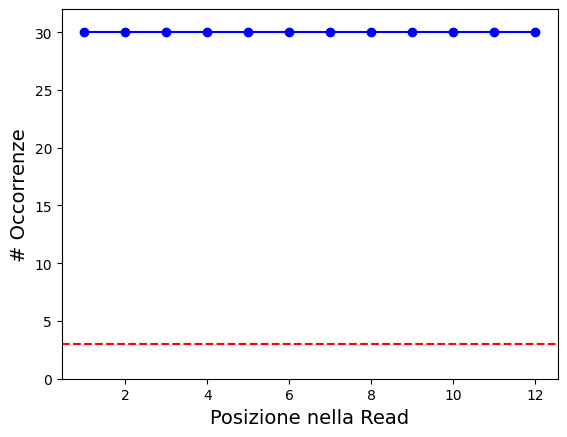

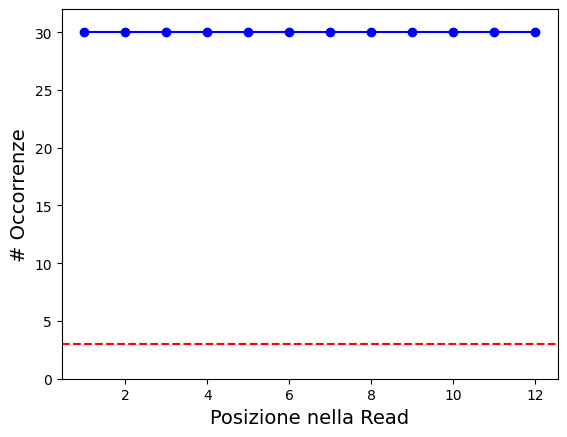

In [51]:
count = count_kmers(fixed_reads2, k)

plot_kmer_coverage(fixed_reads2[0], count, threshold_error=threshold_error)
plot_kmer_coverage(fixed_reads2[1], count, threshold_error=threshold_error)
plot_kmer_coverage(fixed_reads2[2], count, threshold_error=threshold_error)

Le read sono state tutte corrette.

In [18]:
fixed_G = DeBrujin(fixed_reads2, 8)

fixed_assembled2 = fixed_G.assembly()

print(f"# of node in the De Brujin graph with errors {len(G)}")
print(f"# of node in the De Brujin graph without errors {len(fixed_G)}")

print(f"The original sequence is {original_sequence}")
print(f"The assembled sequence is {assembled2} "+("(CORRECT)" if original_sequence==assembled2 else "(WRONG)"))
print(f"The assembled sequence on the fixed reads is {fixed_assembled2} "
      + ("(CORRECT)" if original_sequence==fixed_assembled2 else "(WRONG)"))

# of node in the De Brujin graph with errors 32
# of node in the De Brujin graph without errors 13
The original sequence is GCGTATTACGCGTCTGGCCT
The assembled sequence is GCGTATTACACGTATGGCCTGCGTCTGGCCTATCTGGCCT (WRONG)
The assembled sequence on the fixed reads is GCGTATTACGCGTCTGGCCT (CORRECT)


Il grafo di de Brujin costruito a partire dalle read corrette è più compatto di quello delle read con errori e produce l'assemblato corretto.